In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

%matplotlib inline

failed to find corner on: ./camera_cal/calibration1.jpg
failed to find corner on: ./camera_cal/calibration4.jpg
failed to find corner on: ./camera_cal/calibration5.jpg


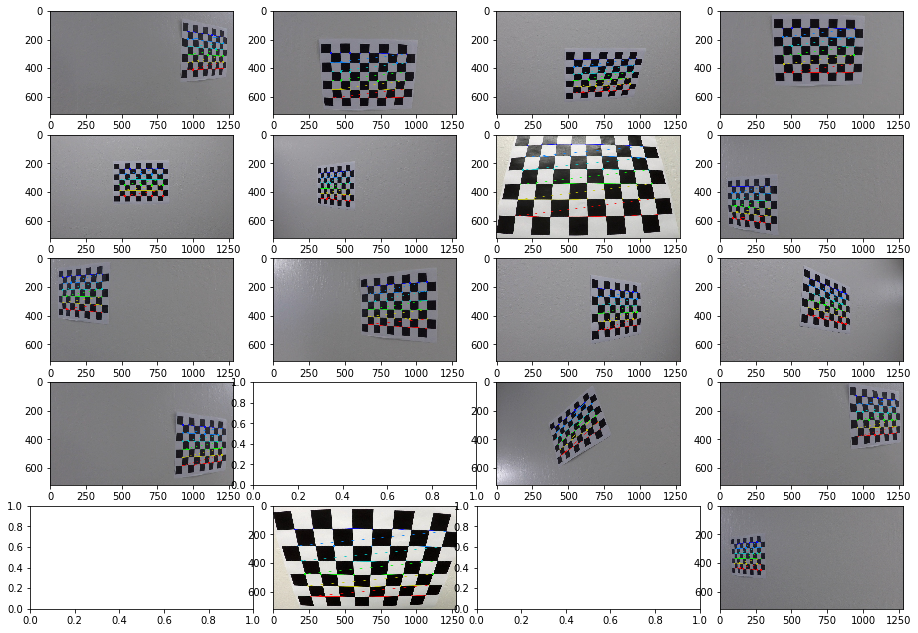

In [2]:
#Step 1. Calibrate camera
#1.1 find chessboard corners and get the calibration matrix
import glob
camera_cals = glob.glob("./camera_cal/*.jpg")
nx=9
ny=6

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)# initialize x, y coordinates to grid, z to zero
calibration_imgs = []

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

w = h = 0
for i, imgf in enumerate(camera_cals):
    img =mpimg.imread(imgf) 
    calibration_imgs.append(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if not ret:
        print("failed to find corner on:", imgf)
    else:    
        imgpoints.append(corners)
        objpoints.append(objp)
        img_t = img.copy()
        img_t = cv2.drawChessboardCorners(img_t, (nx,ny), corners, ret)
        axs[i].imshow(img_t)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)

Failed in finding corners for 3 images with given number of chessboard corners so they don't appear here.

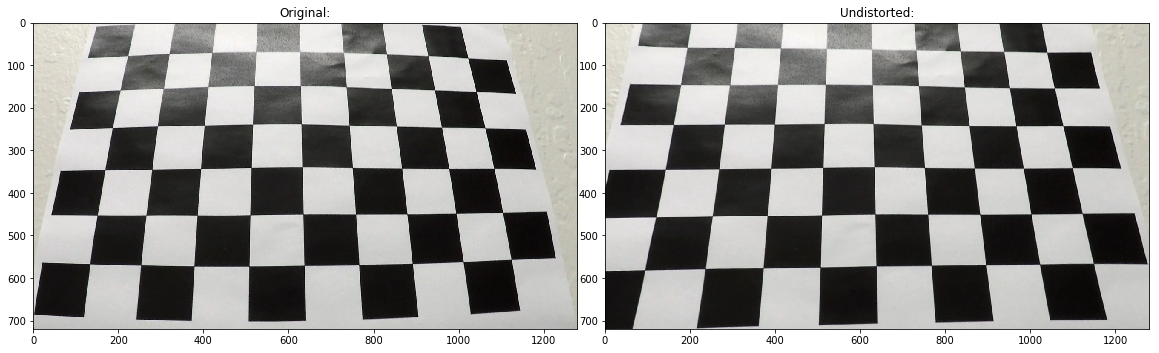

In [3]:
#Check distort correction with one of calibration images
img = calibration_imgs[6]
undst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original:')
ax2.imshow(undst)
ax2.set_title('Undistorted:')

In [4]:
#load test images
tests = sorted(glob.glob("./test_images/*.jpg"))
n = len(tests)
test_imgs = []
w = h = 0
for i, imgf in enumerate(tests):
    img = cv2.imread(imgf)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    w,h = img.shape[1::-1]
    test_imgs.append(img)
    print (i, imgf)

0 ./test_images/straight_lines1.jpg
1 ./test_images/straight_lines2.jpg
2 ./test_images/test1.jpg
3 ./test_images/test2.jpg
4 ./test_images/test3.jpg
5 ./test_images/test4.jpg
6 ./test_images/test5.jpg
7 ./test_images/test6.jpg


In [154]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    unwarped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return unwarped

Next step is to do a perspective transform

(720, 1280, 3)


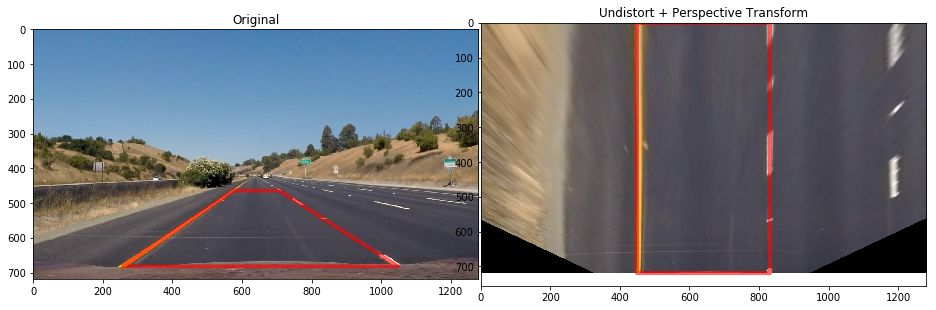

In [155]:
example_img = test_imgs[0].copy()
print (example_img.shape)
undistored_img = undistort(example_img)
transformed_img = unwarp(undistored_img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.subplots_adjust(hspace = .2, wspace=.005)
ax1.imshow(example_img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
#ax1.set_ylim([h,0])
#ax1.set_xlim([0,w])
ax1.set_title('Original')

ax2.imshow(transformed_img)
x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Undistort + Perspective Transform')


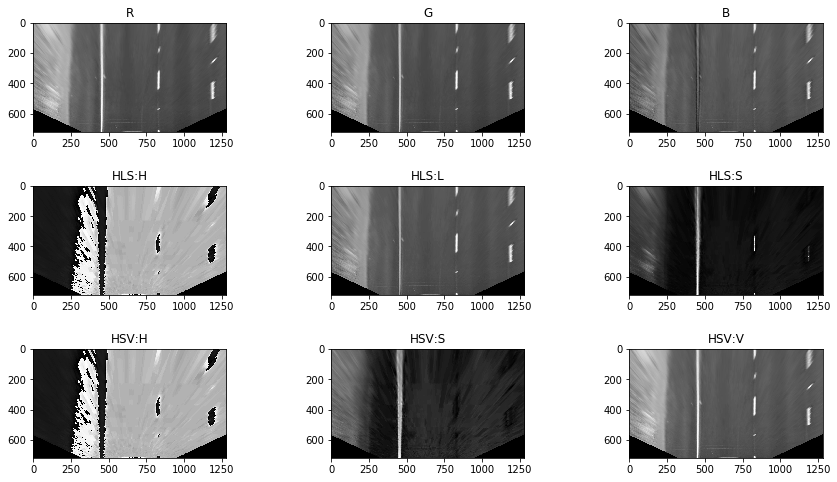

In [144]:
image = transformed_img
r = image[:,:, 0]
g = image[:,:, 1]
b = image[:,:, 2]
f, axs = plt.subplots(3, 3, figsize=(16,8))
f.subplots_adjust(hspace = 0.5, wspace=.005)
axs = axs.ravel()
axs[0].imshow(r, cmap='gray')
axs[0].set_title("R")
axs[1].imshow(g, cmap='gray')
axs[1].set_title("G")
axs[2].imshow(b, cmap='gray')
axs[2].set_title("B")

hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
hls_h = hls_img[:,:,0]
hls_l = hls_img[:,:,1]
hls_s = hls_img[:,:,2]

axs[3].imshow(hls_h, cmap='gray')
axs[3].set_title("HLS:H")
axs[4].imshow(hls_l, cmap='gray')
axs[4].set_title("HLS:L")
axs[5].imshow(hls_s, cmap='gray')
axs[5].set_title("HLS:S")

hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hsv_h = hsv_img[:,:,0]
hsv_s = hsv_img[:,:,1]
hsv_v = hsv_img[:,:,2]

axs[6].imshow(hsv_h, cmap='gray')
axs[6].set_title("HSV:H")
axs[7].imshow(hsv_s, cmap='gray')
axs[7].set_title("HSV:S")
axs[8].imshow(hsv_v, cmap='gray')
axs[8].set_title("HSV:V")


both HSV V channel (HSV:V) and HLS S channel(HLS:S) can caputre the wihte and yellow lines and seperate them out of background well. 

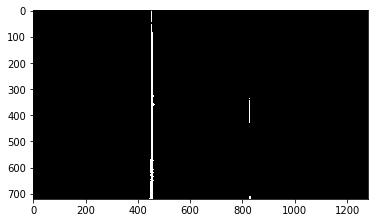

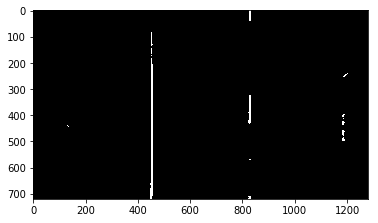

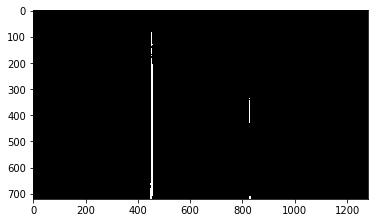

In [49]:
bin_s = np.zeros_like(hls_s)
bin_s[(hls_s>=150) & (hls_s<=255)] = 1
plt.imshow(bin_s, cmap='gray')
plt.show()
bin_v = np.zeros_like(hsv_v)
bin_v[(hsv_v>=230) & (hsv_v<=255)] = 1
plt.imshow(bin_v, cmap='gray')
plt.show()
combined = np.zeros_like(hls_s)
combined[(bin_s == 1) & (bin_v == 1)] = 1
plt.imshow(combined, cmap='gray')

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # If img is in RGB format, Convert to grayscale
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y'))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


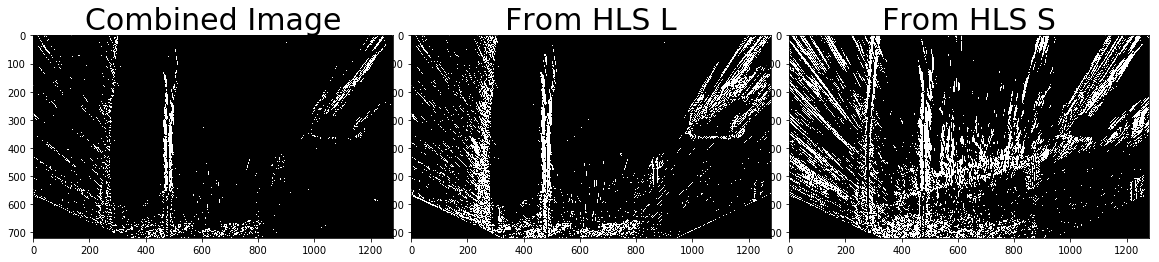

In [11]:
def update(thresh_min, thresh_max):
    img0 = abs_sobel_thresh(hsv_s, 'x',thresh_min, thresh_max)
    img1 = abs_sobel_thresh(hsv_v, 'x',thresh_min, thresh_max)
    combined = np.zeros_like(img0)
    combined[((img0 == 1) & (img1 == 1))] = 1
    
    # Visualize sobel direction threshold
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(combined, cmap='gray')
    axs[0].set_title('Combined Image', fontsize=30)
    axs[1].imshow(img0, cmap='gray')
    axs[1].set_title('From HLS L', fontsize=30)
    axs[2].imshow(img1, cmap='gray')
    axs[2].set_title('From HLS S', fontsize=30)

interact(update, thresh_min=(0,255),
                 thresh_max=(0,255))

The Sobel on HLS:S channel gives the best result for this image.

In [12]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

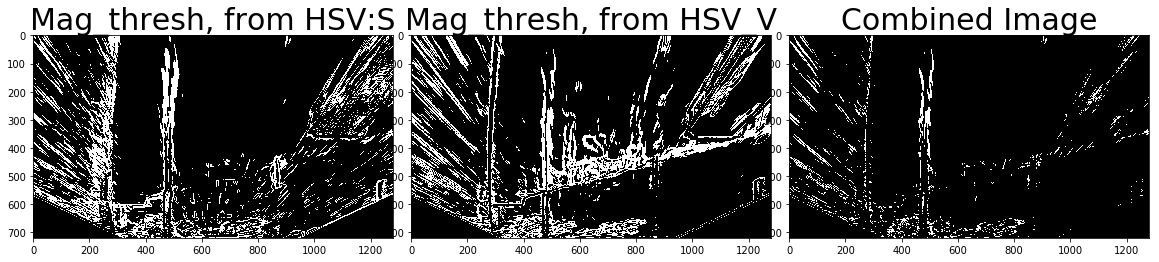

In [13]:
def update(kernel_size, thresh_min, thresh_max):
    img0 = mag_thresh(hsv_s, kernel_size,(thresh_min, thresh_max))
    img1 = mag_thresh(hsv_v, kernel_size,(thresh_min, thresh_max))
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    # Visualize sobel direction threshold
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(img0, cmap='gray')
    axs[0].set_title('Mag_thresh, from HSV:S', fontsize=30)
    axs[1].imshow(img1, cmap='gray')
    axs[1].set_title('Mag_thresh, from HSV_V', fontsize=30)
    axs[2].imshow(combined, cmap='gray')
    axs[2].set_title('Combined Image', fontsize=30)

interact(update, kernel_size=(1,31,2),
                 thresh_min=(0,255),
                 thresh_max=(0,255))

In [14]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

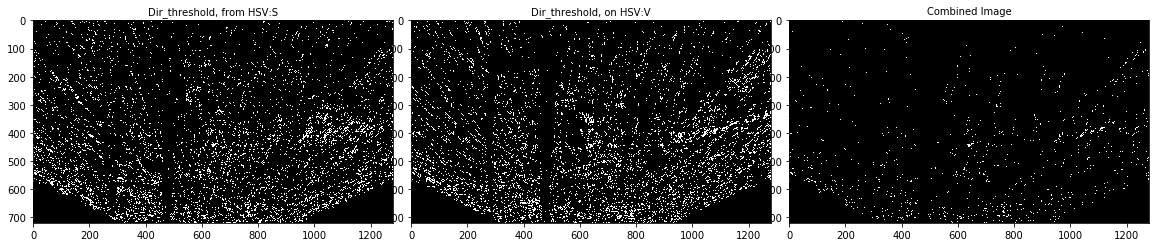

In [16]:
def update(kernel_size, thresh_min, thresh_max):
    img0 = dir_threshold(hsv_s, kernel_size,(thresh_min, thresh_max))
    img1 = dir_threshold(hsv_v, kernel_size,(thresh_min, thresh_max))
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    # Visualize sobel direction threshold
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(img0, cmap='gray')
    axs[0].set_title('Dir_threshold, from HSV:S', fontsize=10)
    axs[1].imshow(img1, cmap='gray')
    axs[1].set_title('Dir_threshold, on HSV:V', fontsize=10)
    axs[2].imshow(combined, cmap='gray')
    axs[2].set_title('Combined Image', fontsize=10)
    
interact(update, kernel_size=(1,31,2), 
                 thresh_min=(0,np.pi/2,0.01), 
                 thresh_max=(0,np.pi/2,0.01))


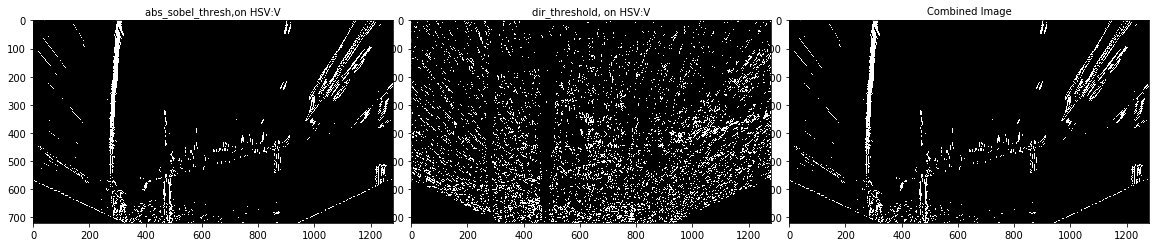

In [18]:
def update(kernel_size, abs_thresh_min, abs_thresh_max, dir_thresh_min, dir_thresh_max):
    img0 = abs_sobel_thresh(hsv_v, 'x',abs_thresh_min, abs_thresh_max)
    img1 = dir_threshold(hsv_v, kernel_size,(dir_thresh_min, dir_thresh_max))
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 0)] = 1
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(img0, cmap='gray')
    axs[0].set_title('abs_sobel_thresh,on HSV:V', fontsize=10)
    axs[1].imshow(img1, cmap='gray')
    axs[1].set_title('dir_threshold, on HSV:V', fontsize=10)
    axs[2].imshow(combined, cmap='gray')
    axs[2].set_title('Combined Image', fontsize=10)

interact(update, kernel_size=(1,31,2), 
                 dir_thresh_min=(0,np.pi/2,0.01), 
                 dir_thresh_max=(0,np.pi/2,0.01),
                 abs_thresh_min=(0,255),
                 abs_thresh_max=(0,255))
#15, 15, 70, 0.05, 0.24            

In [184]:
def image_pipeline(img):
    img  = undistort(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2] #S
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_v = hsv[:,:,2] #V
    bin_sv = np.zeros_like(hls_s)
    #bin_sv[((hls_s>=150)&(hls_s<=255)) & ((hsv_v>=230)&(hsv_v<=255))] = 1
    #bin_sv[((hls_s>=150)&(hls_s<=255))] = 1
    #bin_sv[(((hsv_v>=230)&(hsv_v<=255)))] = 1
    img0 = abs_sobel_thresh(hsv_v, 'x',10, 255)
    img1 = abs_sobel_thresh(hls_s, 'x',15, 255)
    img2 = mag_thresh(hls_s, 15,(60, 255))
    #img3 = dir_threshold(hsv_v, 15,(0.05, 0.14))
    img3 = dir_threshold(hsv_v, 15,(0.55, 1.35))
    #combined = np.zeros_like(img0)
    #combined[(img0 == 1) & (img1 == 1)] = 1
    #combined, _ = unwarp(combined, src, dst)
    img0 = unwarp(img0, src, dst)
    img1 = unwarp(img1, src, dst)
    img2 = unwarp(img2, src, dst)
    img3 = unwarp(img3, src, dst)
    combined = np.zeros_like(img0)
    combined[(img1 == 1) & (img3 == 1)] = 1
    return combined, img3

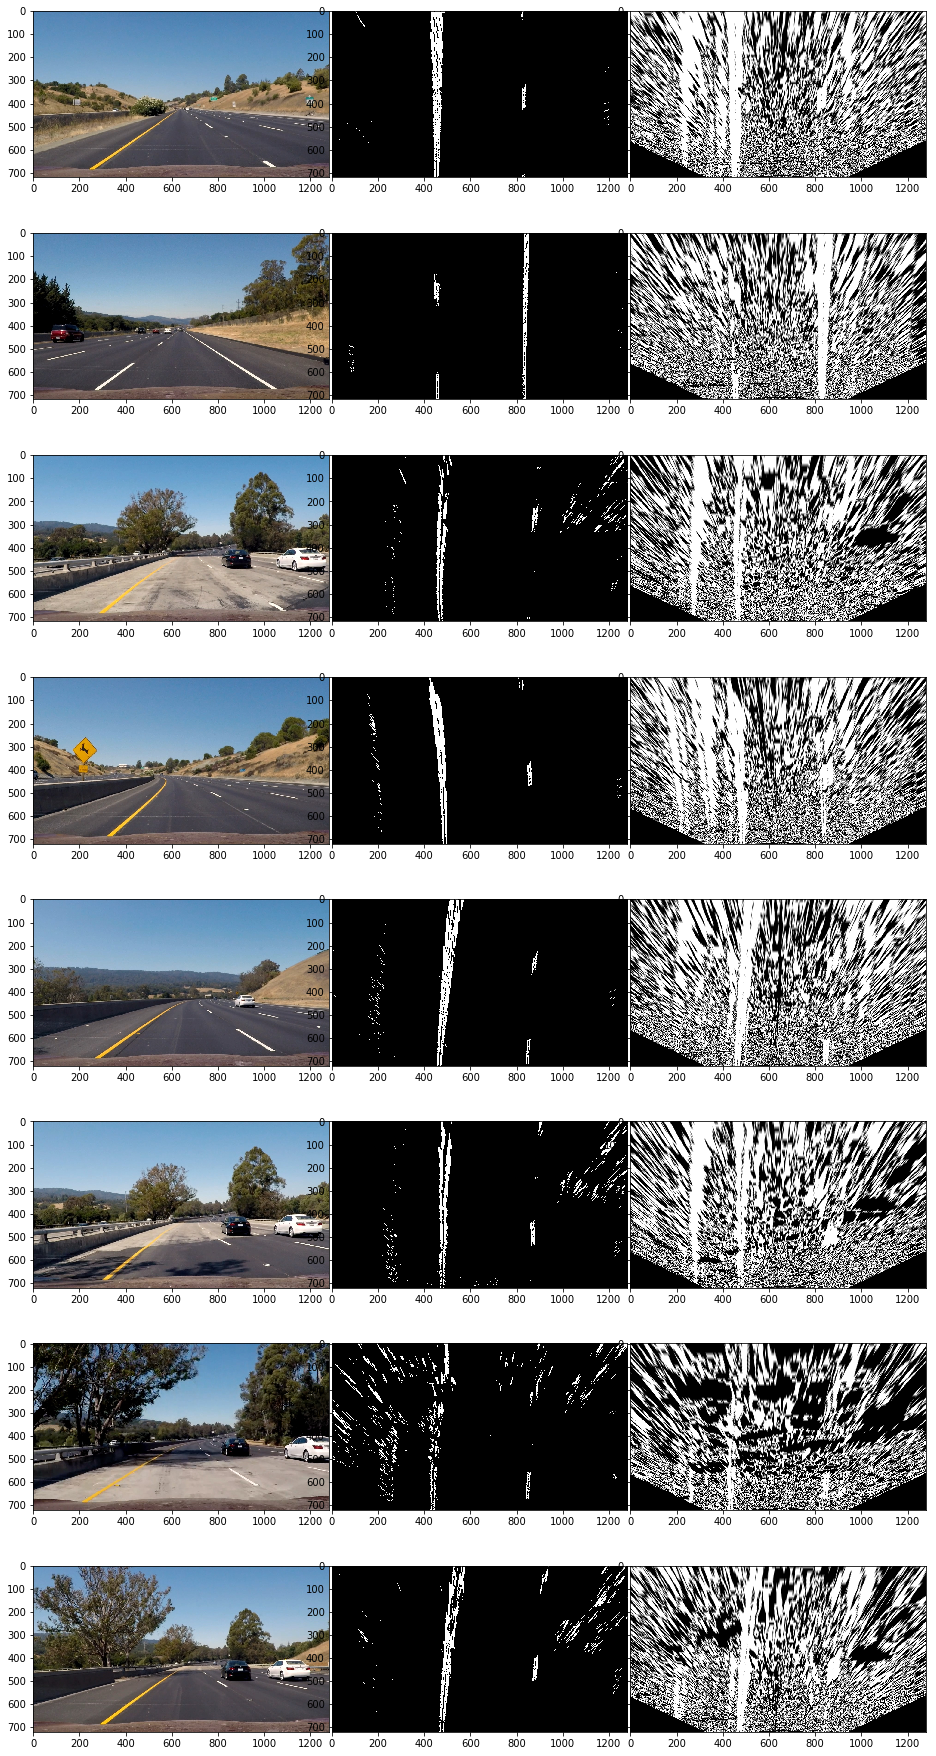

In [185]:
f, axs = plt.subplots(8, 3, figsize=(16,32))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()

for i,img in enumerate(test_imgs):
    img0, img1 = image_pipeline(img)
    axs[3*i].imshow(img)
    axs[3*i+1].imshow(img0,cmap='gray')
    axs[3*i+2].imshow(img1,cmap='gray')


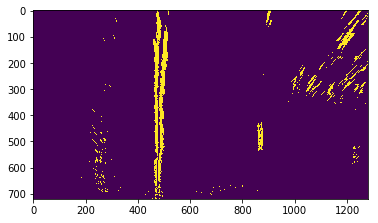

In [186]:
comb, image = image_pipeline(test_imgs[5])
plt.imshow(comb)

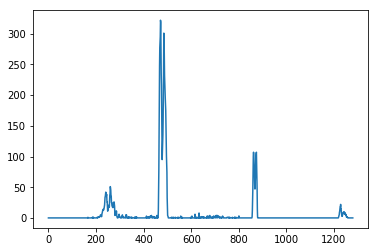

In [187]:
img=comb
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)